Libraries

In [1]:
import argparse
import sys
from pathlib import Path
from typing import List
from typing import Optional
import lithops
import os
import numpy as np
import pathlib
import shutil
import laspy
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

Function used to determine the partition coordinates

In [2]:
def square_split(x_min, y_min, x_max, y_max, square_splits):
    x_size = (x_max - x_min) / square_splits
    y_size = (y_max - y_min) / square_splits
    
    bounds = []
    for i in range(square_splits):
        for j in range(square_splits):
            x_min_bound = (x_size * i) + x_min
            y_min_bound = (y_size * j) + y_min
            x_max_bound = x_min_bound + x_size
            y_max_bound = y_min_bound + y_size
            bounds.append((x_min_bound, y_min_bound, x_max_bound, y_max_bound))
    return bounds

Total Cost Function

In [3]:
def get_process_cost(fexec):
    import pandas as pd
    df = pd.read_csv(fexec.log_path)
    cost = float(df[df["Job_ID"] == "Summary"]["Cost"])
    return cost

Main Variables

In [4]:
bucketName = 'lidars-particionados-cutre-arnau-uwu'
square_splits = 2
points_per_iter = 500_000

Partition Function

In [5]:
def spliter(obj, ibm_cos):
    filename = obj.key.split("/")[-1]
    
    #Create local directory to store partitions
    tmp_path_prefix = '/partitions/'
    if os.path.exists(tmp_path_prefix):
        shutil.rmtree(tmp_path_prefix)
    os.makedirs(tmp_path_prefix)

    tile_key = pathlib.Path(obj.key).stem
    
    #Download file to partition
    ibm_cos.download_file(bucketName, obj.key, "/tmp/" + filename)
    
    #Convert to .LAS if necessary
    if filename.endswith(".laz"):
        lidar = laspy.read("/tmp/" + filename)
        lidar = laspy.convert(lidar)
        filename = filename.split(".")[0] + ".las"
        lidar.write("/tmp/" + filename)
    
    #Partition
    with laspy.open("/tmp/" + filename) as file:
        sub_bounds = square_split(
            file.header.x_min,
            file.header.y_min,
            file.header.x_max,
            file.header.y_max,
            square_splits)

        writers: List[Optional[laspy.LasWriter]] = [None] * len(sub_bounds)
        try:
            count = 0
            for points in file.chunk_iterator(points_per_iter):
                print(f"{count / file.header.point_count * 100}%")

                # For performance we need to use copy
                # so that the underlying arrays are contiguous
                x, y = points.x.copy(), points.y.copy()

                point_piped = 0

                for i, (x_min, y_min, x_max, y_max) in enumerate(sub_bounds):
                    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)

                    if np.any(mask):
                        if writers[i] is None:
                            output_path = os.path.join(tmp_path_prefix, f"{tile_key}_{i}" + '.las')
                            writers[i] = laspy.open(output_path,
                                                    mode='w',
                                                    header=file.header)
                        sub_points = points[mask]
                        writers[i].write_points(sub_points)

                    point_piped += np.sum(mask)
                    if point_piped == len(points):
                        break
                count += len(points)
            print(f"{count / file.header.point_count * 100}%")
        finally:
            for writer in writers:
                if writer is not None:
                    writer.close()
                    
                  
    #SUBIR ARCHIVOS AL CLOUD
    for file in os.listdir("/partitions"):
        path = "/partitions/" + file
        destinationPath = "partitions/" + pathlib.Path(obj.key).stem + "/" + file
        ibm_cos.upload_file(path, bucketName, destinationPath)

    return os.path.getsize("/tmp/" + filename)/(1024*1024)

Main

In [6]:
fexec = lithops.FunctionExecutor(runtime='arnaugabriel/lithopspartitioner:1.0')

2022-06-15 11:25:24,969 [INFO] lithops.config -- Lithops v2.6.0
2022-06-15 11:25:25,076 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-06-15 11:25:25,077 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: lithops_testing_functions


In [7]:
INPUT_DATA_PREFIX = r'catalunya/'
DATA_BUCKET = r'lidars-particionados-cutre-arnau-uwu'

fexec.map(spliter, f'cos://{DATA_BUCKET}/{INPUT_DATA_PREFIX}')
sizes = fexec.get_result()

2022-06-15 11:25:25,083 [INFO] lithops.invokers -- ExecutorID 180ada-0 | JobID M000 - Selected Runtime: arnaugabriel/lithopspartitioner:1.0 - 2048MB
2022-06-15 11:25:25,807 [INFO] lithops.invokers -- ExecutorID 180ada-0 | JobID M000 - Starting function invocation: spliter() - Total: 516 activations
2022-06-15 11:25:26,298 [INFO] lithops.invokers -- ExecutorID 180ada-0 | JobID M000 - View execution logs at /tmp/lithops/logs/180ada-0-M000.log
2022-06-15 11:25:26,308 [INFO] lithops.wait -- ExecutorID 180ada-0 - Getting results from 516 function activations


    0%|          | 0/516  

2022-06-15 11:26:32,560 [INFO] lithops.executors -- ExecutorID 180ada-0 - Cleaning temporary data


KPIs

In [8]:
    if not os.path.exists("plots"):
        os.makedirs("plots")
    fexec.plot(dst="plots/partition")

2022-06-15 11:26:32,840 [INFO] lithops.executors -- ExecutorID 180ada-0 - Creating execution plots


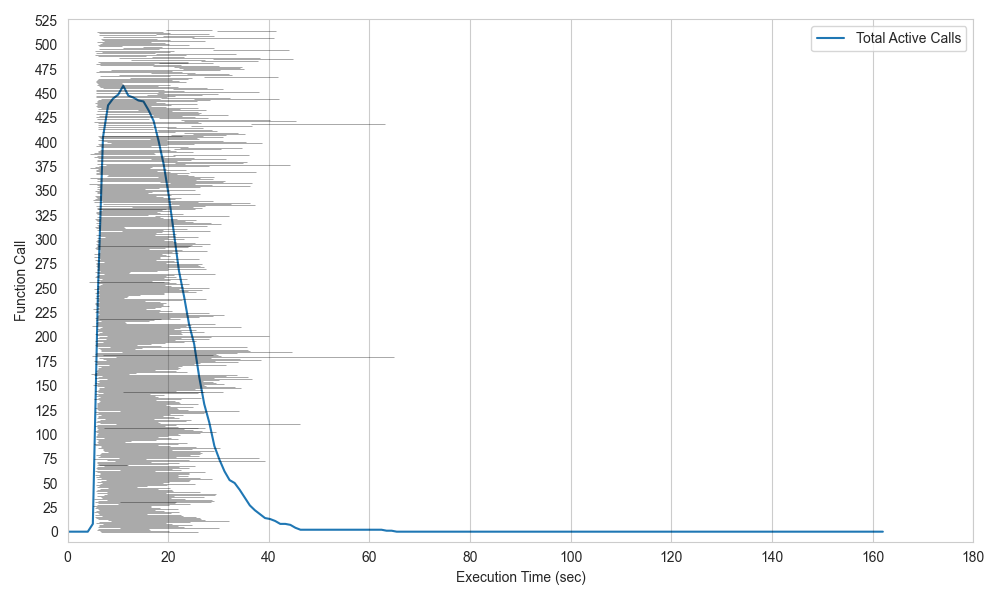

In [9]:
    Image(filename="plots/partition_histogram.png")

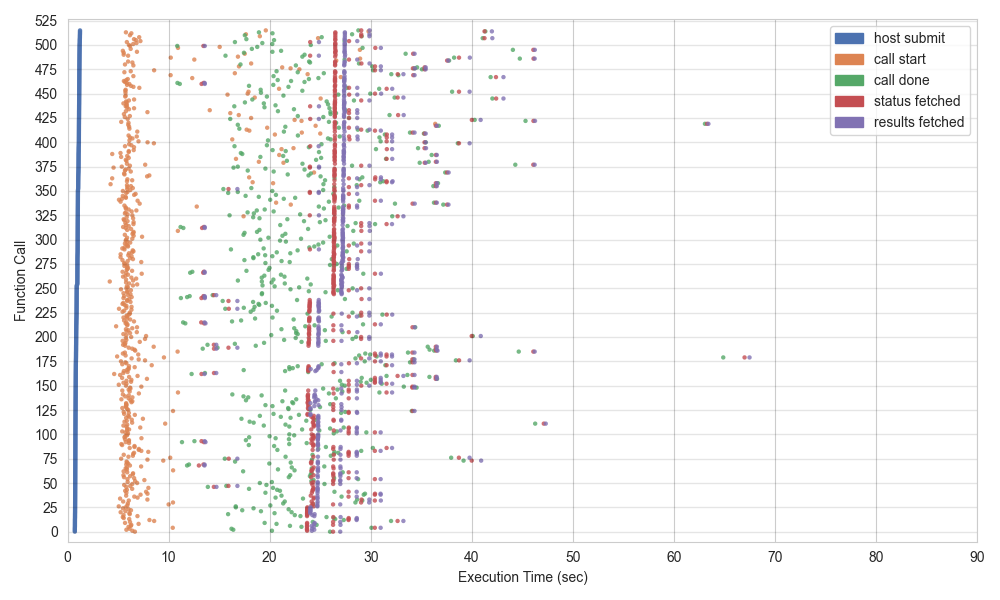

In [10]:
    Image(filename="plots/partition_timeline.png")

Data Size

In [11]:
    data_size = sum(sizes)
    print(f"Data size: {data_size} MB")

Data size: 79340.4188079834 MB


KPI: Cost

In [12]:
    fexec.job_summary()
    pd.read_csv(fexec.log_path)

    cost_interpolation = get_process_cost(fexec)
    print(f"The experiment cost ${cost_interpolation:.4f}.")

2022-06-15 11:26:33,312 [INFO] lithops.executors -- View log file logs at /tmp/lithops/logs/2022-06-15_11:26:33.csv


The experiment cost $0.2867.


KPI: Thoughput

In [13]:
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])

    duration = max(tstamps) - min(tstamps)
    print("Duration: " + str(duration) + " seconds")

    throughput_interpolation = data_size / duration

    print(f"Throughput: {throughput_interpolation} MB/s")

Duration: 67.4718759059906 seconds
Throughput: 1175.9035560020502 MB/s
